# Create Figure 2 for KRAS cis effect

This notebook creates a boxplot for the cis effect of KRAS missense mutationsin 3 cancers. These 3 cancers were chosen because they have enough samples with KRAS missense mutations to do a t-test.

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import plot_utils as p

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Functions:

format_df prepares a data frame with KRAS proteomics and KRAS mutation type from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [2]:
'''
Params
all_prot: list of trans genes
utils: from cptac

Returns a dataframe with trans proteomics and mutation status (KRAS missense or wt)
'''

def format_df(cancer_object, all_prot, gene_in = 'KRAS', utils = u):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    # Keep only tumor samples from proteomics
    prot_and_mutations = cancer_object.join_omics_to_mutations(
        mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot,
        tissue_type = 'tumor') # drop Normal samples
        
    # Reduce a multiindex 
    if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
        prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1) 

    # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
    mut_type = mut_type[['Mutation']] 
    mut_type["Mutation"] = mut_type['Mutation'].replace(['nonsynonymous SNV'], 'Missense_Mutation')#for colon
    prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
    merged = prot_df.join(mut_type)
        
    # Keep only Wildtype and Missense
    compare = ['Wildtype_Tumor','Missense_Mutation']
    get = merged['Mutation'].isin(compare)
    missense_wt = merged[get]
    return missense_wt
 


In [3]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Step 1: Create data frames with KRAS missense and Proteomics

Each cancer needs a data frame containing only samples that have KRAS missense or KRAS wildtype tumors and KRAS proteomics.

First, load in cancer data sets from cptac.

In [4]:
en = cptac.Endometrial()
l = cptac.Luad()
col = cptac.Colon()


In [5]:
gene = "KRAS"

Next, use format_df to create the specific data frame for each cancer. Use wrap_ttest to test KRAS missense vs. wildtype. 

# Luad

In [6]:
l_miss_wt = format_df(l, gene)
l_miss_wt
l_pval = u.wrap_ttest(l_miss_wt, 'Mutation', ['KRAS_proteomics'],return_all=True)
lp = l_pval.P_Value[0]
l_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 76 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 77 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 15)


,Comparison,P_Value
0,KRAS_proteomics,0.114481


# Colon

In [7]:
c_miss_wt = format_df(col, gene)
c_pval = u.wrap_ttest(c_miss_wt, 'Mutation', ['KRAS_proteomics'], return_all=True)
cp = c_pval.P_Value[0]
c_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 71 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 15)
cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: 01CO001, 05CO005, 05CO007, 05CO014, 05CO055, 11CO059, 11CO060, 14CO002, 16CO012, 24CO005 (

,Comparison,P_Value
0,KRAS_proteomics,0.01079


# Endometrial

The Endometrial data set does not have enough cnv deletions to perform a t-test, however the data set does have enough truncation type mutations (nonsense and frame shifts). Different code is needed to create the data frame for Endometrial.

In [8]:
en_miss_wt = format_df(en, gene)
en_pval = u.wrap_ttest(en_miss_wt, 'Mutation', ['KRAS_proteomics'],return_all=True)
ep = en_pval.P_Value[0]
en_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 64 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 64 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 15)


,Comparison,P_Value
0,KRAS_proteomics,0.005531


# Step 2: Create a long dataframe for the boxplot

The boxplot will take three columns: Proteomics, Mutation, and Cancer. We need to append all the individual cancer dfs into one long pancancer df. 

First create the Cancer column.

In [9]:

l_miss_wt = l_miss_wt.assign(cancer = 'Luad')
c_miss_wt = c_miss_wt.assign(cancer = 'Colon')
en_miss_wt = en_miss_wt.assign(cancer = 'Endometrial')


Next append the dfs.

In [10]:
df = l_miss_wt.append(c_miss_wt)
df2 = df.append(en_miss_wt)
df2

Name,KRAS_proteomics,Mutation,cancer
Patient_ID,,,
C3L-00009,NaN,Wildtype_Tumor,Luad
C3L-00083,-0.3416,Wildtype_Tumor,Luad
C3L-00094,0.5142,Missense_Mutation,Luad
C3L-00095,-0.9424,Wildtype_Tumor,Luad
C3L-00140,-0.7216,Wildtype_Tumor,Luad
...,...,...,...
C3N-01520,0.6620,Missense_Mutation,Endometrial
C3N-01521,-0.4350,Missense_Mutation,Endometrial
C3N-01537,-0.1370,Wildtype_Tumor,Endometrial


# Step 3: Create the Pancancer Boxplot

p-values: 

Luad 0.11448064454827266 

Colon 0.010790315848871903 

Endo 0.005530656769015996 



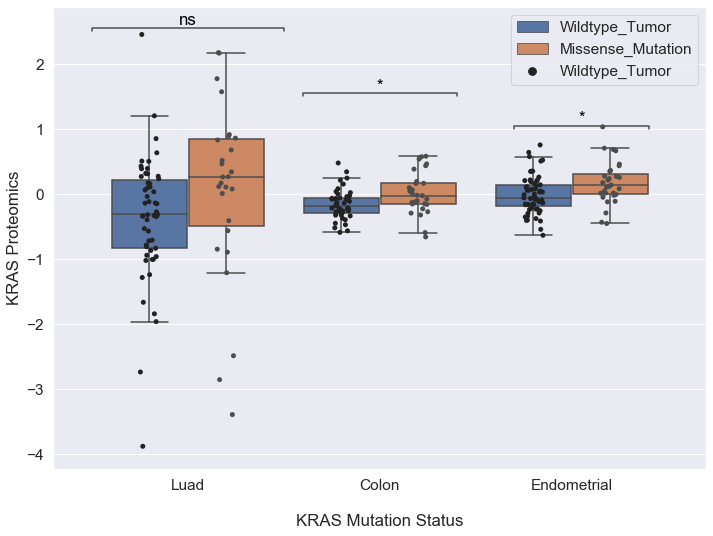

In [11]:
# cis plot
gene = 'KRAS'
plt.rcParams['figure.figsize']=(11.7, 8.5) #size of plot
sns.set(font_scale = 1.4)

boxplot = sns.boxplot(x='cancer', y=gene+"_proteomics", data = df2, hue = 'Mutation',
                      hue_order = ["Wildtype_Tumor", "Missense_Mutation"], showfliers = False)    
#boxplot.set_title('Pancancer cis effect of KRAS Missense')
boxplot = sns.stripplot(x='cancer', y=gene+"_proteomics", data = df2, jitter = True, 
                           color = ".3", hue = 'Mutation', hue_order = ["Wildtype_Tumor", "Missense_Mutation"], dodge = True)
boxplot.set(xlabel = "\nKRAS Mutation Status", ylabel = gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])

# Create significance symbols:
# * P < 0.015   ** P < 0.001   *** P < 0.0001 
cancer_pvals = {'Luad':lp, 'Colon':cp, 'Endo':ep}

# create pval annotations
symbols = {}
print('p-values: \n')
for cancer in cancer_pvals:
    val = str(cancer_pvals[cancer])
    if cancer_pvals[cancer]  < 0.0001:
        symbols[cancer] = '***'
    elif cancer_pvals[cancer]  < 0.001:
        symbols[cancer] = '**'  
    elif cancer_pvals[cancer]  < 0.015:
        symbols[cancer] = '*'
    elif cancer_pvals[cancer]  > 0.05:
        symbols[cancer] = 'ns'
    print(cancer, val, '\n')

 
    #format_pval_annotation(symbols['Luad'], .7, 1, 2.2) 
    
format_pval_annotation(symbols['Luad'], -0.5, 0.5, 2.5)  # Luad
format_pval_annotation(symbols['Colon'], 0.6, 1.4, 1.5)  # Colon
format_pval_annotation(symbols['Endo'], 1.7, 2.4, 1) # Endometrial
plt.show()
plt.clf()
plt.close()

In [12]:
# Save figure
fig = boxplot.get_figure()
fig.savefig("KRAS_missense_cis_effect.png", dpi = 300)

# Hot Spot G12

In [13]:
#use get_somatic mutation not get genotype due to priority order for gen_genotype_all_vars
luad_mut_type = l.get_somatic_mutation()
luad_miss = luad_mut_type.loc[luad_mut_type['Mutation'] == "Missense_Mutation"]
luad_miss = luad_miss.loc[luad_miss['Gene'] == "KRAS"]
hotspots = luad_miss.groupby('Location').count()
l_hotspot_G12 = hotspots[(hotspots.index.str.contains('G12') | hotspots.index.str.contains('G13') |hotspots.index.str.contains('Q61'))]
l_hotspot_G12 = l_hotspot_G12.rename(columns={"Mutation": "Number of Mutations Luad"})
l_hotspot_G12 = l_hotspot_G12[["Number of Mutations Luad"]]
l_hotspot_G12

Name,Number of Mutations Luad
Location,
p.G12A,1
p.G12C,16
p.G12D,6
p.G12S,2
p.G12V,5
p.G13C,2
p.Q61H,1


In [14]:
en_mut_type = en.get_somatic_mutation()
en_miss =en_mut_type.loc[en_mut_type['Mutation'] == "Missense_Mutation"]
en_miss = en_miss.loc[en_miss['Gene'] == "KRAS"]
hotspots = en_miss.groupby('Location').count()
e_hotspot_G12 = hotspots[(hotspots.index.str.contains('G12')| hotspots.index.str.contains('G13') |hotspots.index.str.contains('Q61'))]
e_hotspot_G12 = e_hotspot_G12.rename(columns={"Mutation": "Number of Mutations Endometrial"})
e_hotspot_G12 = e_hotspot_G12[["Number of Mutations Endometrial"]]

e_hotspot_G12

Name,Number of Mutations Endometrial
Location,
p.G12A,1
p.G12C,4
p.G12D,6
p.G12S,1
p.G12V,10
p.G13D,7
p.Q61H,1


In [15]:
col_mut_type = col.get_somatic_mutation()
col_miss =col_mut_type.loc[col_mut_type['Mutation'] == "nonsynonymous SNV"]
col_miss = col_miss.loc[col_miss['Gene'] == "KRAS"]
hotspots = col_miss.groupby('Location').count()
c_hotspot_G12 = hotspots[(hotspots.index.str.contains('G12') | hotspots.index.str.contains('G13') |hotspots.index.str.contains('Q61'))]
c_hotspot_G12 = c_hotspot_G12.rename(columns={"Mutation": "Number of Mutations Colon"})
c_hotspot_G12 = c_hotspot_G12[["Number of Mutations Colon"]]


In [16]:
hotspot_table = l_hotspot_G12.merge(e_hotspot_G12, on = "Location", how = "outer")

hotspot_table.index = hotspot_table.index.str.replace(r'p.', "", regex = True)
hotspot_table = hotspot_table.merge(c_hotspot_G12, on = "Location", how = "outer")
hotspot_table = hotspot_table.fillna(0)

hotspot_table.to_csv('G12_missense_mutations_table.csv')
hotspot_table

Name,Number of Mutations Luad,Number of Mutations Endometrial,Number of Mutations Colon
Location,,,
G12A,1.0,1.0,0.0
G12C,16.0,4.0,2.0
G12D,6.0,6.0,11.0
G12S,2.0,1.0,0.0
G12V,5.0,10.0,7.0
G13C,2.0,0.0,0.0
Q61H,1.0,1.0,2.0
G13D,0.0,7.0,4.0
Q61L,0.0,0.0,1.0


# Cis effect for only C12,C13, Q61 missense mutations

In [17]:
'''
Params
all_prot: list of trans genes
utils: from cptac

Returns a dataframe with trans proteomics and mutation status (KRAS missense or wt)
'''

def hotspot_format_df(cancer_object, all_prot, gene_in = 'KRAS', utils = u):
    
    
    # Keep only tumor samples from proteomics
    prot_and_mutations = cancer_object.join_omics_to_mutations(
        mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot,
        tissue_type = 'tumor') # drop Normal samples
    #Change columns to strings
    
    prot_and_mutations['KRAS_Mutation'] = [','.join(map(str, l)) for l in prot_and_mutations['KRAS_Mutation']]
    prot_and_mutations['KRAS_Location'] = [','.join(map(str, l)) for l in prot_and_mutations['KRAS_Location']]
    
    # Reduce a multiindex 
    if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
        prot_and_mutations = u.reduce_multiindex(prot_and_mutations, levels_to_drop = 1) 
    mut_type = prot_and_mutations
    #mut_type["Mutation"] = mut_type['Mutation'].replace(['nonsynonymous SNV'], 'Missense_Mutation')#for colon
    hotspot = mut_type[(mut_type.KRAS_Location.str.contains('G12'))| 
                    mut_type.KRAS_Location.str.contains('G13')| 
                    mut_type.KRAS_Location.str.contains('Q61')]
    wt = mut_type[(mut_type.KRAS_Mutation.str.contains('Wildtype'))]
    hotspot_wt = pd.concat([hotspot, wt]) 
    #prot_df = hotspot_wt.iloc[:,:-3] # Keep only proteomics
 
    
    return hotspot_wt

In [18]:
l_hot_wt = hotspot_format_df(l, gene)
l_hot_wt


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 77 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 15)


Name,KRAS_proteomics,KRAS_Mutation,KRAS_Location,KRAS_Mutation_Status,Sample_Status
Patient_ID,,,,,
C3L-00094,0.5142,Missense_Mutation,p.G12D,Single_mutation,Tumor
C3L-00263,-3.3885,Missense_Mutation,p.G12C,Single_mutation,Tumor
C3L-00279,0.4615,Missense_Mutation,p.G12D,Single_mutation,Tumor
C3L-00412,-2.8517,Missense_Mutation,p.G12C,Single_mutation,Tumor
C3L-00913,-0.8486,Missense_Mutation,p.G13C,Single_mutation,Tumor
...,...,...,...,...,...
C3N-02588,-0.7875,Wildtype_Tumor,No_mutation,Wildtype_Tumor,Tumor
C3N-02729,-0.2732,Wildtype_Tumor,No_mutation,Wildtype_Tumor,Tumor
X11LU013,0.8489,Wildtype_Tumor,No_mutation,Wildtype_Tumor,Tumor


In [19]:
l_hot_wt = hotspot_format_df(l, gene)
purity = l.get_derived_molecular()
purity = purity[["Tumor.Purity.byESTIMATE.RNAseq"]]
merged = l_hot_wt.merge(purity, on = "Patient_ID", how = "left")
merged = merged.dropna()
merged = merged.sort_values(by = "Tumor.Purity.byESTIMATE.RNAseq")
luad_t_pure = merged.loc[merged['Tumor.Purity.byESTIMATE.RNAseq'] > 0.45]

luad_hot_pval = u.wrap_ttest(luad_t_pure, 'KRAS_Mutation', ['KRAS_proteomics'],return_all=True)
lp_hotspot = luad_hot_pval.P_Value[0]

luad_hot_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 77 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 15)


,Comparison,P_Value
0,KRAS_proteomics,0.02922


In [20]:

luad_hot_pval2 = u.wrap_ttest(l_hot_wt, 'KRAS_Mutation', ['KRAS_proteomics'],return_all=True)
lp_hotspot2 = luad_hot_pval2.P_Value[0]
luad_hot_pval2

,Comparison,P_Value
0,KRAS_proteomics,0.253346


In [21]:
c_hot_wt = hotspot_format_df(col, gene)

purity = col.get_derived_molecular()
purity = purity[["TumorPurity"]]
merged = c_hot_wt.merge(purity, on = "Patient_ID", how = "left")
merged = merged.dropna()
merged = merged.sort_values(by = "TumorPurity")

col_t_pure = merged.loc[merged['TumorPurity'] > 0.45]
col_hot_pval = u.wrap_ttest(col_t_pure, 'KRAS_Mutation', ['KRAS_proteomics'],return_all=True)
col_hotspot = col_hot_pval.P_Value[0]
col_hot_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 15)
cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: 01CO001, 05CO005, 05CO007, 05CO014, 05CO055, 11CO059, 11CO060, 14CO002, 16CO012, 24CO005 (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 15)


,Comparison,P_Value
0,KRAS_proteomics,0.061823


In [22]:

col_hot_pval2 = u.wrap_ttest(c_hot_wt, 'KRAS_Mutation', ['KRAS_proteomics'],return_all=True)
col_hotspot2 = col_hot_pval2.P_Value[0]
col_hot_pval2

,Comparison,P_Value
0,KRAS_proteomics,0.065578


In [23]:
en_hot_wt = hotspot_format_df(en, gene)
purity = en.get_derived_molecular()
purity = purity[["Purity_Cancer"]]
merged = en_hot_wt.merge(purity, on = "Patient_ID", how = "left")
merged = merged.dropna()
merged = merged.sort_values(by = "Purity_Cancer")
en_t_pure = merged.loc[merged['Purity_Cancer'] > 0.45]
en_t_pure.at['C3L-00008', 'KRAS_Mutation']  = "Missense_Mutation" #corrected double missense mutation

en_hot_pval = u.wrap_ttest(en_t_pure, 'KRAS_Mutation', ['KRAS_proteomics'],return_all=True)
en_hotspot = en_hot_pval.P_Value[0]
en_hot_pval


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 64 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 15)


,Comparison,P_Value
0,KRAS_proteomics,0.045386


In [24]:
en_hot_wt = hotspot_format_df(en, gene)

en_hot_wt.at['C3L-00008', 'KRAS_Mutation']  = "Missense_Mutation"
en_hot_pval2 = u.wrap_ttest(en_hot_wt, 'KRAS_Mutation', ['KRAS_proteomics'],return_all=True)
en_hotspot2 = en_hot_pval2.P_Value[0]
en_hot_pval2

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 64 samples for the KRAS gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 15)


,Comparison,P_Value
0,KRAS_proteomics,0.016973


In [25]:
col_t_pure =  col_t_pure.replace(to_replace = r'nonsynonymous SNV', value = 'Hotspot_Mutation', regex = True)
l_hot_wt = luad_t_pure.assign(cancer = 'Luad')
c_hot_wt = col_t_pure.assign(cancer = 'Colon')
en_hot_wt = en_t_pure.assign(cancer = 'Endometrial')

In [26]:
df = l_hot_wt.append(c_hot_wt)
df2_hotspot = df.append(en_hot_wt)
df2_hotspot =  df2_hotspot.replace(to_replace = r'Missense_Mutation', value = 'Hotspot_Mutation', regex = True)
df2_hotspot

,KRAS_proteomics,KRAS_Mutation,KRAS_Location,KRAS_Mutation_Status,Sample_Status,Tumor.Purity.byESTIMATE.RNAseq,cancer,TumorPurity,Purity_Cancer
Patient_ID,,,,,,,,,
C3N-02423,0.2598,Hotspot_Mutation,p.G12C,Single_mutation,Tumor,0.451350,Luad,NaN,NaN
C3N-00556,1.5687,Hotspot_Mutation,p.G12C,Single_mutation,Tumor,0.460828,Luad,NaN,NaN
C3N-02003,0.0921,Wildtype_Tumor,No_mutation,Wildtype_Tumor,Tumor,0.469318,Luad,NaN,NaN
C3N-01489,0.3391,Hotspot_Mutation,p.G12V,Single_mutation,Tumor,0.472088,Luad,NaN,NaN
C3N-01488,-0.1074,Hotspot_Mutation,p.G12D,Single_mutation,Tumor,0.472440,Luad,NaN,NaN
...,...,...,...,...,...,...,...,...,...
C3N-01510,0.2050,Wildtype_Tumor,No_mutation,Wildtype_Tumor,Tumor,NaN,Endometrial,NaN,0.753031
C3N-00377,0.5730,Wildtype_Tumor,No_mutation,Wildtype_Tumor,Tumor,NaN,Endometrial,NaN,0.763209
C3N-00858,0.0413,Wildtype_Tumor,No_mutation,Wildtype_Tumor,Tumor,NaN,Endometrial,NaN,0.763673


p-values: 

Luad 0.029219955033721722 

Colon 0.06182336991722686 

Endo 0.04538577182710845 



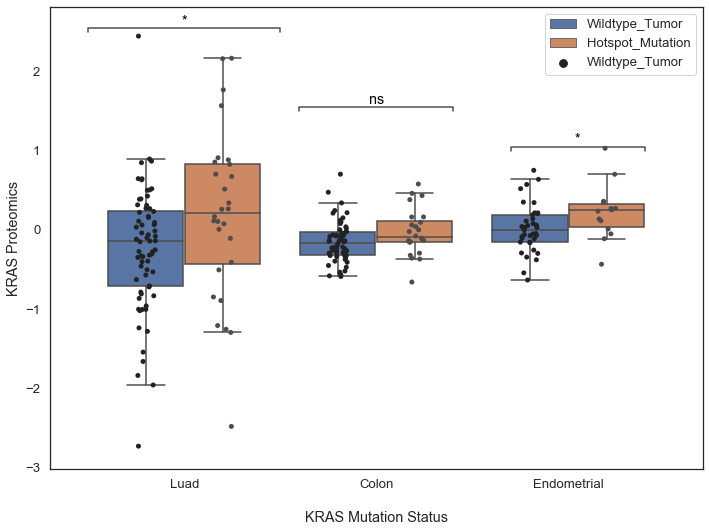

In [31]:
# cis plot
gene = 'KRAS'
plt.rcParams['figure.figsize']=(11.7, 8.5) #size of plot

sns.set(font_scale = 1.2, style = "white")

boxplot = sns.boxplot(x='cancer', y=gene+"_proteomics", data = df2_hotspot, hue = 'KRAS_Mutation'
                      ,hue_order = ["Wildtype_Tumor", "Hotspot_Mutation"], showfliers = False)   
#boxplot.set_title('Pancancer cis effect of KRAS Missense')
boxplot = sns.stripplot(x='cancer', y=gene+"_proteomics", data = df2_hotspot, jitter = True, 
                           color = ".3", hue = 'KRAS_Mutation', hue_order = ["Wildtype_Tumor", "Hotspot_Mutation"], dodge = True)
boxplot.set(xlabel = "\nKRAS Mutation Status", ylabel = gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])

# Create significance symbols:
# * P < 0.015   ** P < 0.001   *** P < 0.0001 
cancer_pvals = {'Luad':lp_hotspot, 'Colon':col_hotspot, 'Endo':en_hotspot}

# create pval annotations
symbols = {}
print('p-values: \n')
for cancer in cancer_pvals:
    val = str(cancer_pvals[cancer])
    if cancer_pvals[cancer]  < 0.0001:
        symbols[cancer] = '***'
    elif cancer_pvals[cancer]  < 0.001:
        symbols[cancer] = '**'  
    elif cancer_pvals[cancer]  < 0.05:
        symbols[cancer] = '*'
    elif cancer_pvals[cancer]  > 0.05:
        symbols[cancer] = 'ns'
    print(cancer, val, '\n')


format_pval_annotation(symbols['Luad'], -0.5, 0.5, 2.5)  # Luad
format_pval_annotation(symbols['Colon'], 0.6, 1.4, 1.5)  # Colon
format_pval_annotation(symbols['Endo'], 1.7, 2.4, 1) # Endometrial
plt.show()
plt.clf()
plt.close()

In [28]:
# Save figure
fig = boxplot.get_figure()
fig.savefig("KRAS_hotspot_cis_effect.png", dpi = 300)